# COGS 118C Final Project Notebook
WI25

**Group**: CJDD (Cooper Ward, Jonathan Fuller, David Pamplona, Danny Rivera)

**Title**: Resting-State EEG Analysis for Alzheimer's Detection

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import ttest_ind, shapiro, mannwhitneyu
import mne
mne.set_log_level('WARNING')

We will focus on 10 control subjects and 10 Alzheimer's subjects for our project, and we will limit our analysis to the channels that seem most relevant, which are F3, F4, T3, T4, O1, and O2.

In [2]:
# Define File Paths and Subject IDs for AD and Control
ad_files = [
    "sub-008_task-eyesclosed_eeg-unprocessed.set",
    "sub-002_task-eyesclosed_eeg-unprocessed.set",
    "sub-003_task-eyesclosed_eeg-unprocessed.set",
    "sub-004_task-eyesclosed_eeg-unprocessed.set",
    "sub-007_task-eyesclosed_eeg-unprocessed.set",
    "sub-025_task-eyesclosed_eeg-unprocessed.set",
    "sub-010_task-eyesclosed_eeg-unprocessed.set",
    "sub-033_task-eyesclosed_eeg-unprocessed.set",
    "sub-028_task-eyesclosed_eeg-unprocessed.set",
    "sub-035_task-eyesclosed_eeg-unprocessed.set"
]
ad_subject_ids = ["Subject 008", "Subject 002", "Subject 003", "Subject 004", "Subject 007",
                  "Subject 025", "Subject 010", "Subject 033", "Subject 028", "Subject 035"]

control_files = [
    "sub-042_task-eyesclosed_eeg-unprocessed.set",
    "sub-039_task-eyesclosed_eeg-unprocessed.set",
    "sub-044_task-eyesclosed_eeg-unprocessed.set",
    "sub-041_task-eyesclosed_eeg-unprocessed.set",
    "sub-046_task-eyesclosed_eeg-unprocessed.set",
    "sub-047_task-eyesclosed_eeg-unprocessed.set",
    "sub-048_task-eyesclosed_eeg-unprocessed.set",
    "sub-049_task-eyesclosed_eeg-unprocessed.set",
    "sub-050_task-eyesclosed_eeg-unprocessed.set",
    "sub-051_task-eyesclosed_eeg-unprocessed.set"
]
control_subject_ids = ["Subject 042", "Subject 039", "Subject 044", "Subject 041",
                       "Subject 046", "Subject 047", "Subject 048", "Subject 049",
                       "Subject 050", "Subject 051"]

# Restrict analysis to relevant channels:
channels_of_interest = ["F3", "F4", "T3", "T4", "O1", "O2"]

## Signal Processing

First, we set up the functions we will use to preprocess and plot the data for our subjects. Here are the details for each function, with explanations for parameter choices:

1) `preprocess_eeg`: Loads the file and adds a FIR bandpass filter. Next, we create a synthetic EOG channel using channels Fp1 and Fp2 to run ICA, identify eye artifacts, and remove them.
    - Bandpass:
        - `l_freq=1` and `h_freq=45`: Pass frequencies between 1 and 45 Hz for our filter, since we are interested in observing the Theta, Alpha and Gamma bands in these frequencies.
        - `fir_design='firwin'`: The specified filter we use, a FIR filter using the window method since we will use Welch's method, which involves windows to divide data.
    - ICA:
        - `random_state=97`: A seed of 97 for the random number generator, to ensure reproducibility.
        - 19 independent components found in each recording, for a total of 190.
        - Most recordings had 1 or 2 eye artifact components related to the EOG channel, so we removed those.
2) `plot_eeg_time_series`: Displays the EEG time series data for the subject across the target channels.
    - `fs=500`: Sampling rate of 500 Hz to match the original dataset.
    - `time_limit=20`: Limit the time-series plots to the first 20 seconds of data.
3) `compute_psd_welch`: Computes the PSD for each channel using Welch's method (`scipy.signal.welch`)
    - `nperseg=1024`: The number of samples taken in each segment. We use 1024, which allows for less segments with a higher frequency resolution.
4) `compute_channel_relative_power`: Take each channel and compute the relative band power.

In [3]:
# Preprocessing Function: Band-pass filter and ICA to remove eye artifacts
def preprocess_eeg(file_path, l_freq=1, h_freq=45.0):
    """
    Loads an EEGLAB .set file, sets a standard 10-20 montage, 
    applies a band-pass filter (1–45 Hz), 
    creates a synthetic EOG channel from Fp1 and Fp2, 
    runs ICA to remove EOG artifacts,
    plots the ICA components for inspection,
    and returns the cleaned Raw object along with the number of removed EOG components.
    """
    # Load raw data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    
    # Create synthetic EOG channel from Fp1 and Fp2
    eog_data = raw.copy().pick_channels(["Fp1", "Fp2"]).get_data().mean(axis=0, keepdims=True)
    info_eog = mne.create_info(["EOG"], sfreq=raw.info["sfreq"], ch_types=["eog"])
    eog_raw = mne.io.RawArray(eog_data, info_eog)
    raw.add_channels([eog_raw])
    print("Synthetic EOG channel created from Fp1 and Fp2.")
    
    # Apply band-pass filter
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design="firwin")
    print(f"Band-pass filter applied: {l_freq}–{h_freq} Hz.")
    
    # Run ICA
    ica = mne.preprocessing.ICA(random_state=97, max_iter="auto")
    ica.fit(raw)
    print(f"Total number of ICA components: {ica.n_components_}")
    
    # Identify EOG-related components
    eog_indices, _ = ica.find_bads_eog(raw, ch_name="EOG")
    ica.exclude = eog_indices
    print("Identified EOG-related ICA components:", eog_indices)
    print("Number of eye artifact components removed:", len(ica.exclude))
    
    # Apply ICA to remove the excluded components
    raw_clean = ica.apply(raw.copy())
    return raw_clean, len(ica.exclude)




# Plot EEG Time Series Function
def plot_eeg_time_series(eeg_data, subject_id, selected_channels, channel_names,
                         colors, fs=500, time_limit=20, ax=None):
    """
    Plots the EEG time series for selected channels.
    """
    n_samples = eeg_data.shape[1]
    time = np.linspace(0, n_samples/fs, n_samples)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
        
    for i, ch_idx in enumerate(selected_channels):
        ax.plot(time, eeg_data[ch_idx, :]*1e6, label=channel_names[i], color=colors[i])
    ax.set_xlim(0, time_limit)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EEG Signal (µV)")
    ax.set_title(f"EEG Time Series for {subject_id}")
    ax.legend(loc='upper right')
    ax.grid(True)





# Welch's Method
def compute_psd_welch(eeg_data, fs=500, nperseg=1024):
    """
    Computes the PSD for each channel using Welch's method.
    Returns frequency bins and PSD array of shape (n_channels, n_freqs).
    """
    n_channels = eeg_data.shape[0]
    psd_list = []
    for ch in range(n_channels):
        freqs, pxx = signal.welch(eeg_data[ch, :]*1e6, fs=fs, nperseg=nperseg)
        psd_list.append(pxx)
    return freqs, np.array(psd_list)





# Channel-wise Relative Band Power Calculation Function
def compute_channel_relative_power(psd, band_mask, broad_mask):
    """
    Computes relative power for each channel as:
        (sum of PSD in the band) / (sum of PSD in the broad range)
    Returns an array of relative power values for each channel.
    """
    total_power = np.sum(psd[:, broad_mask], axis=1)
    band_power = np.sum(psd[:, band_mask], axis=1)
    rel_power = np.divide(band_power, total_power, out=np.zeros_like(band_power), where=total_power != 0)
    return rel_power

Next, we will apply the previous functions to each of our subject files, keeping the sampling frequency at 500 Hz.

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


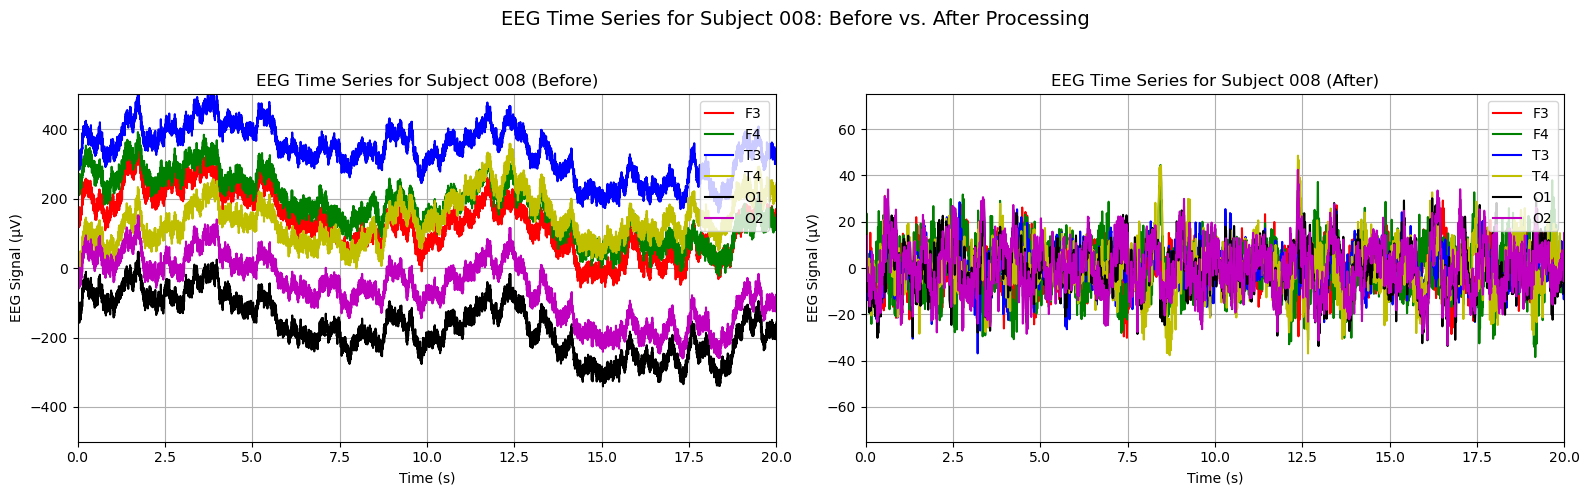

Subject 008: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 2]
Number of eye artifact components removed: 2


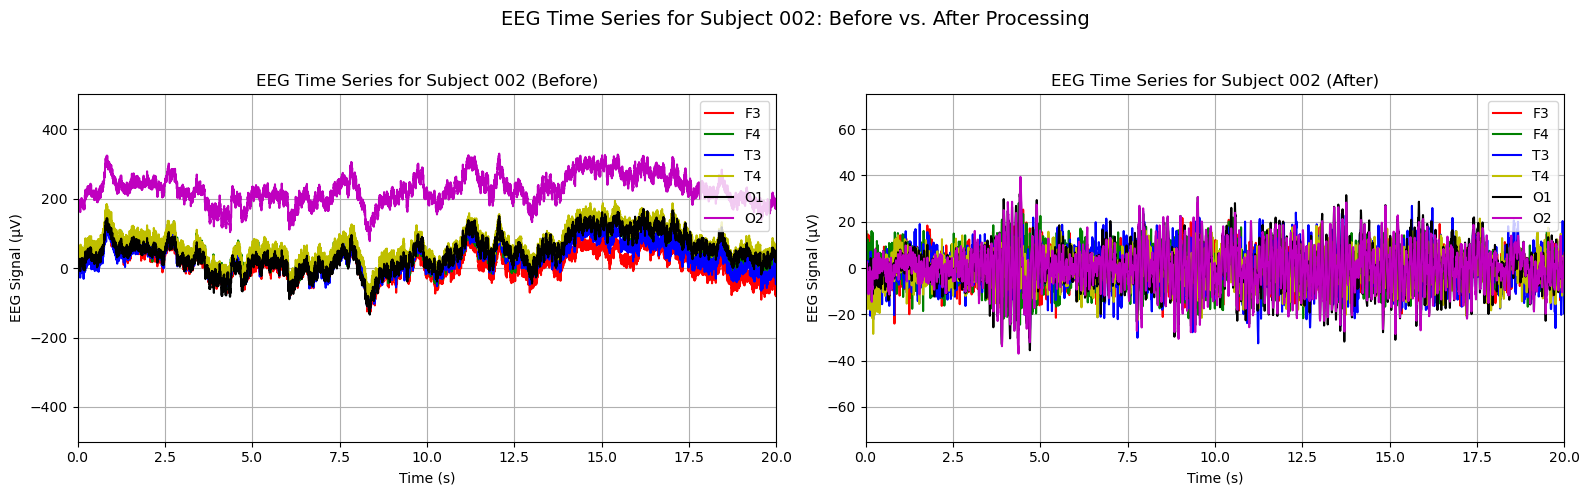

Subject 002: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


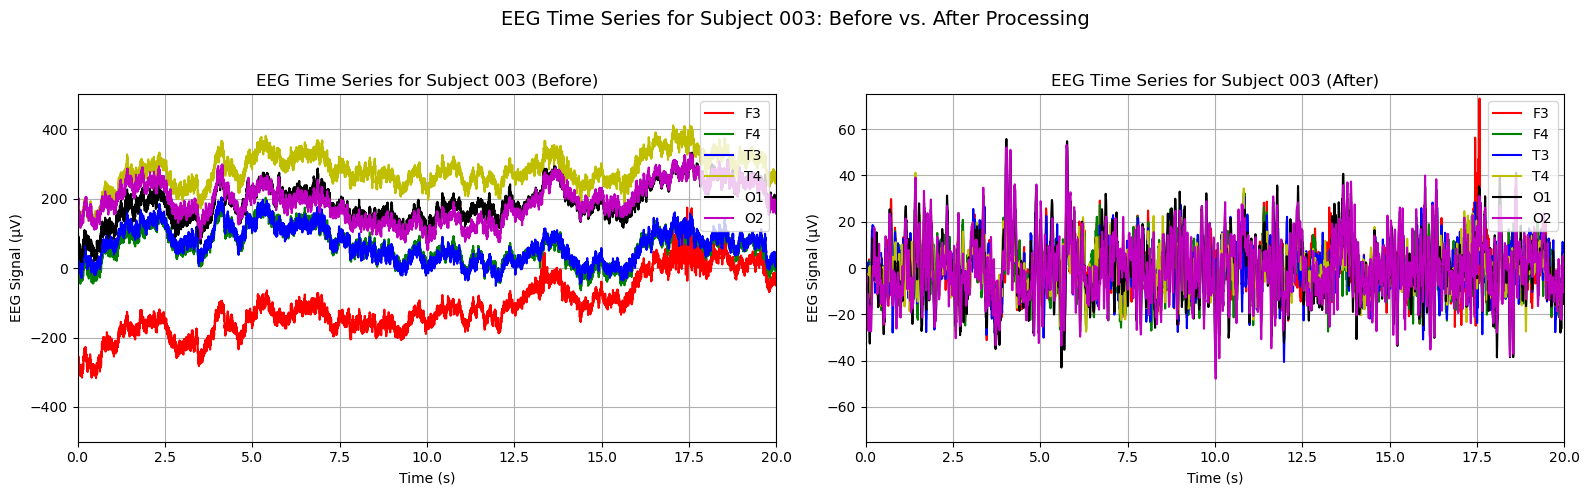

Subject 003: 1 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


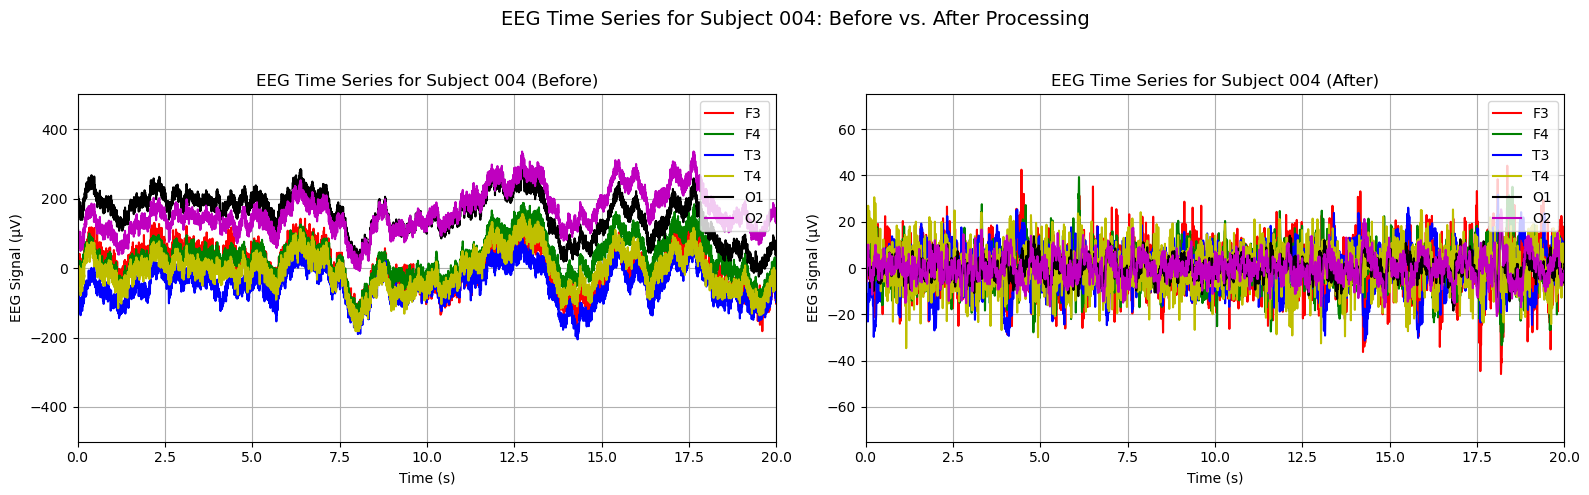

Subject 004: 1 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


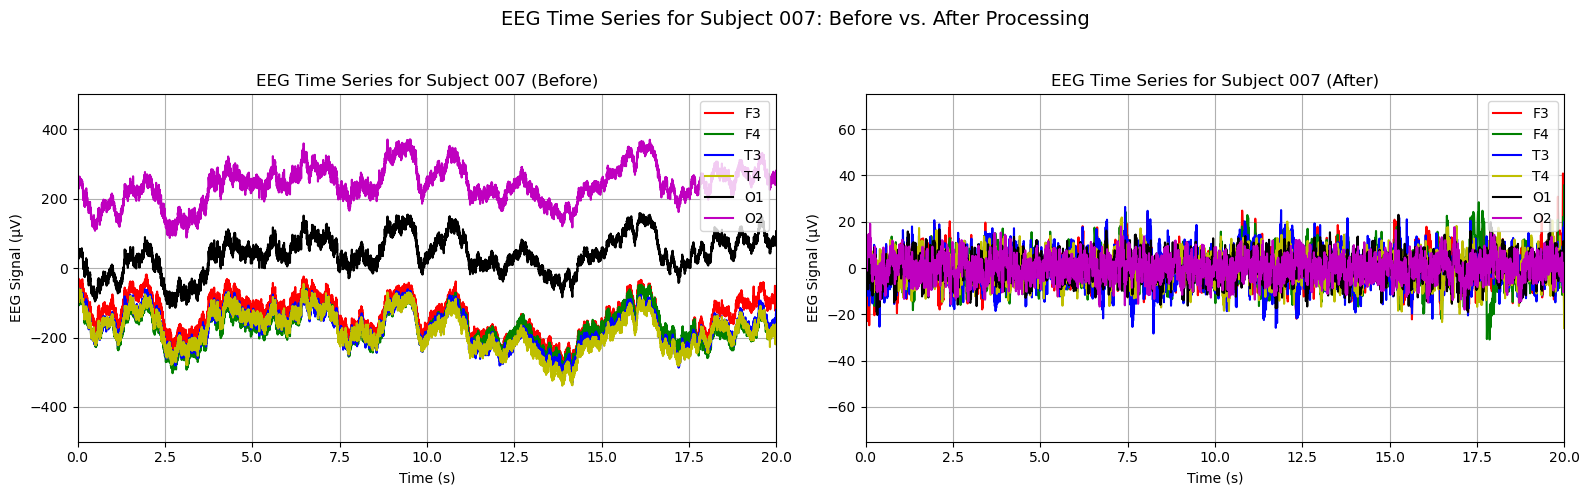

Subject 007: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


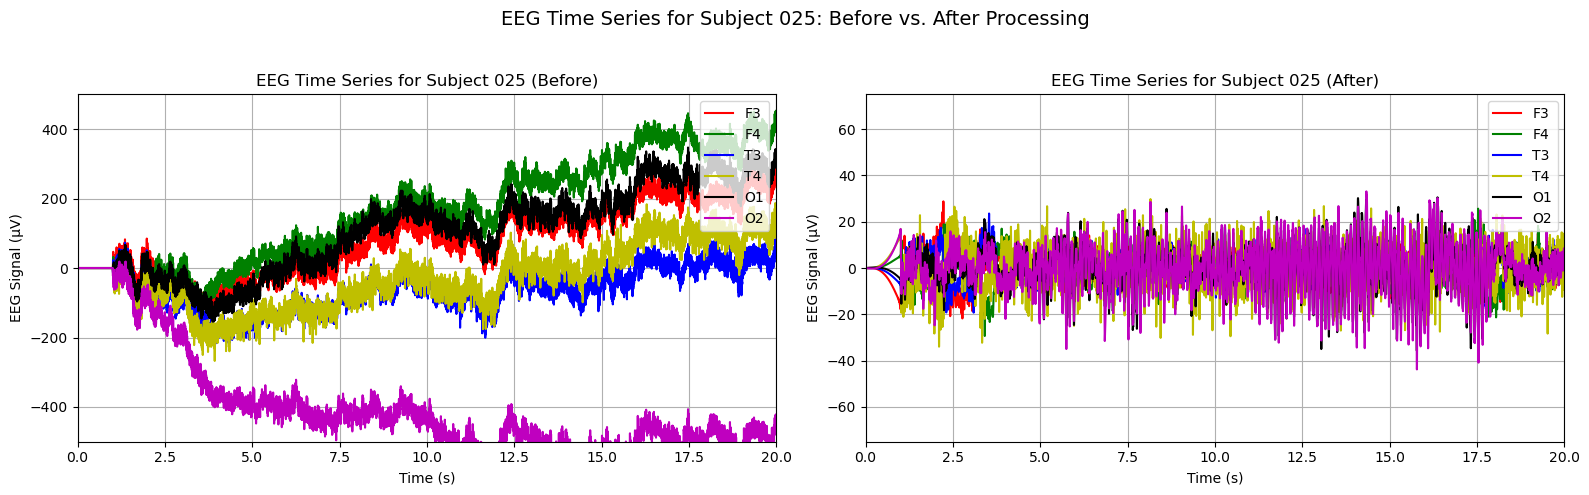

Subject 025: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


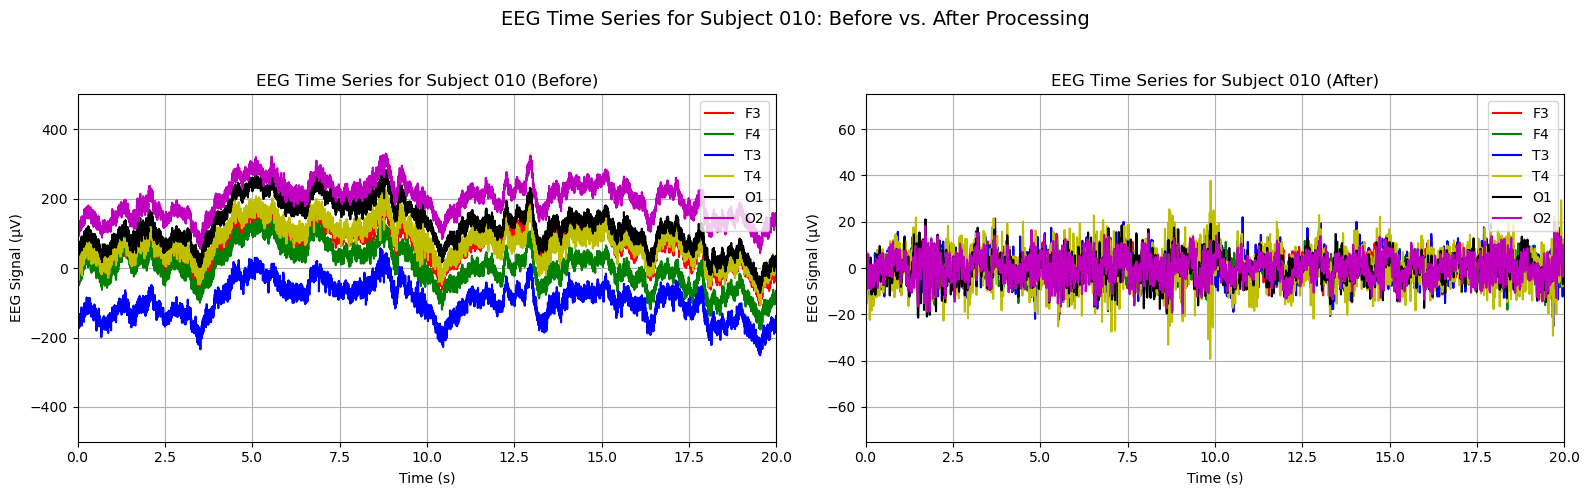

Subject 010: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


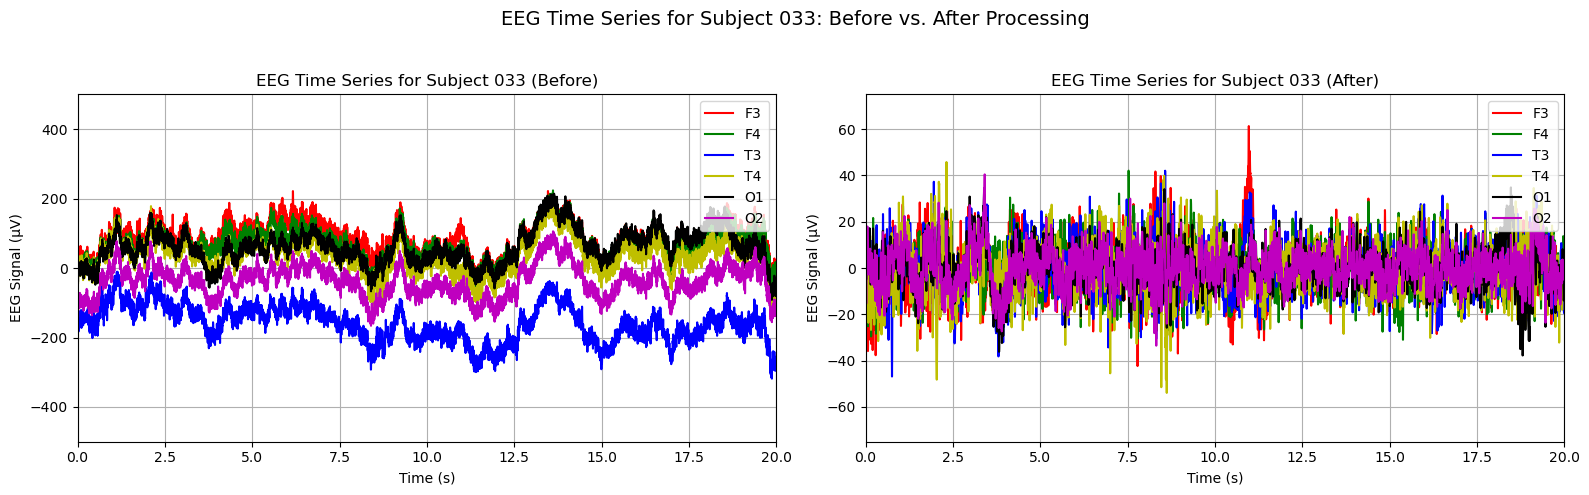

Subject 033: 1 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


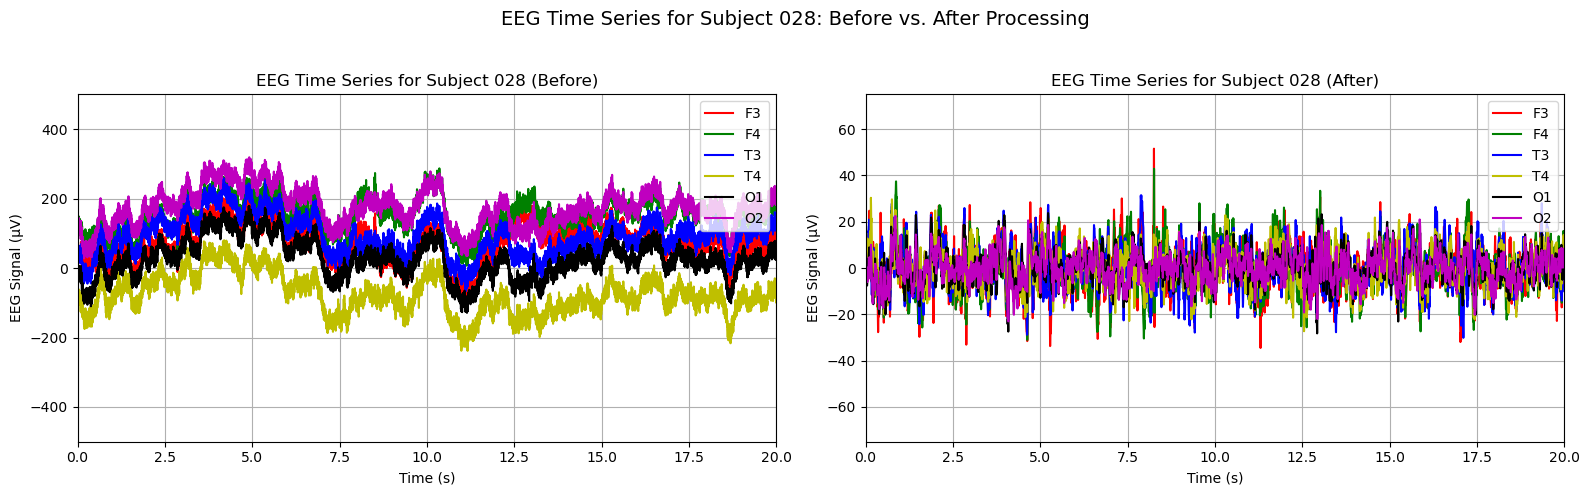

Subject 028: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


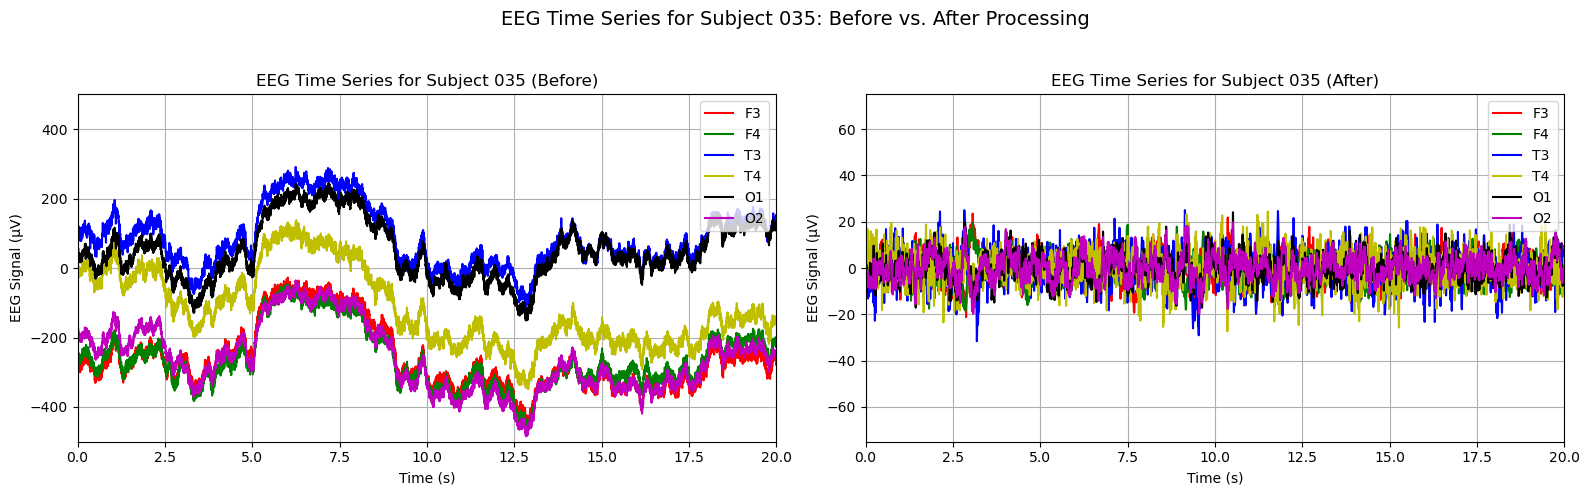

Subject 035: 2 eye artifact components were removed.
Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 3]
Number of eye artifact components removed: 2


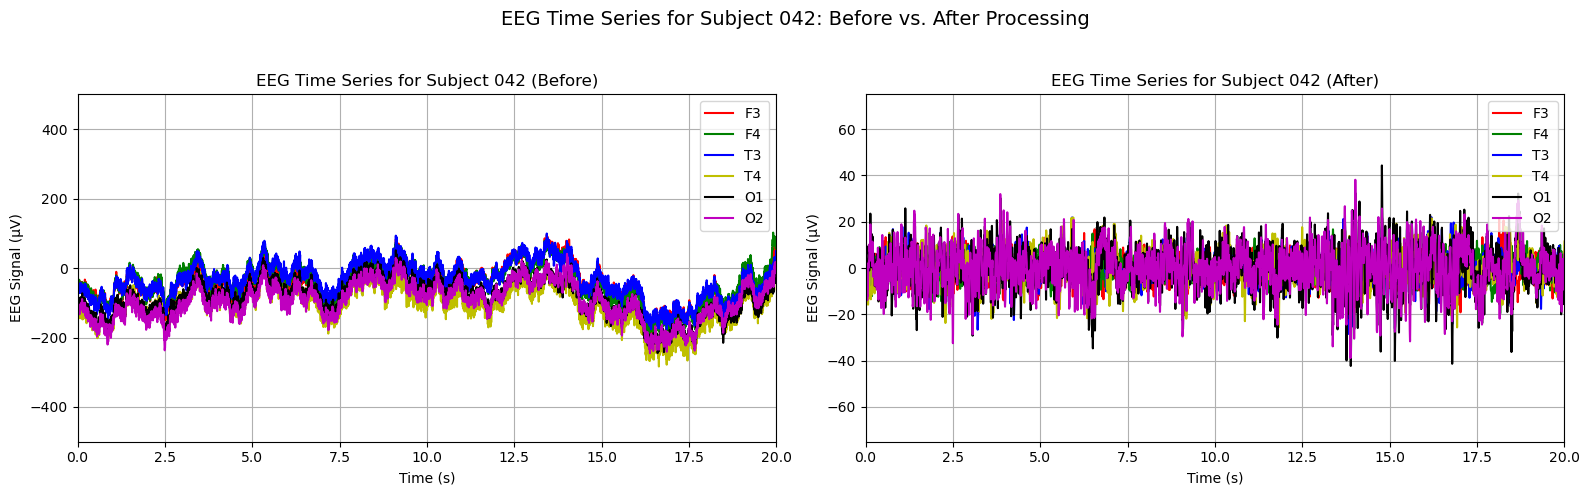

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


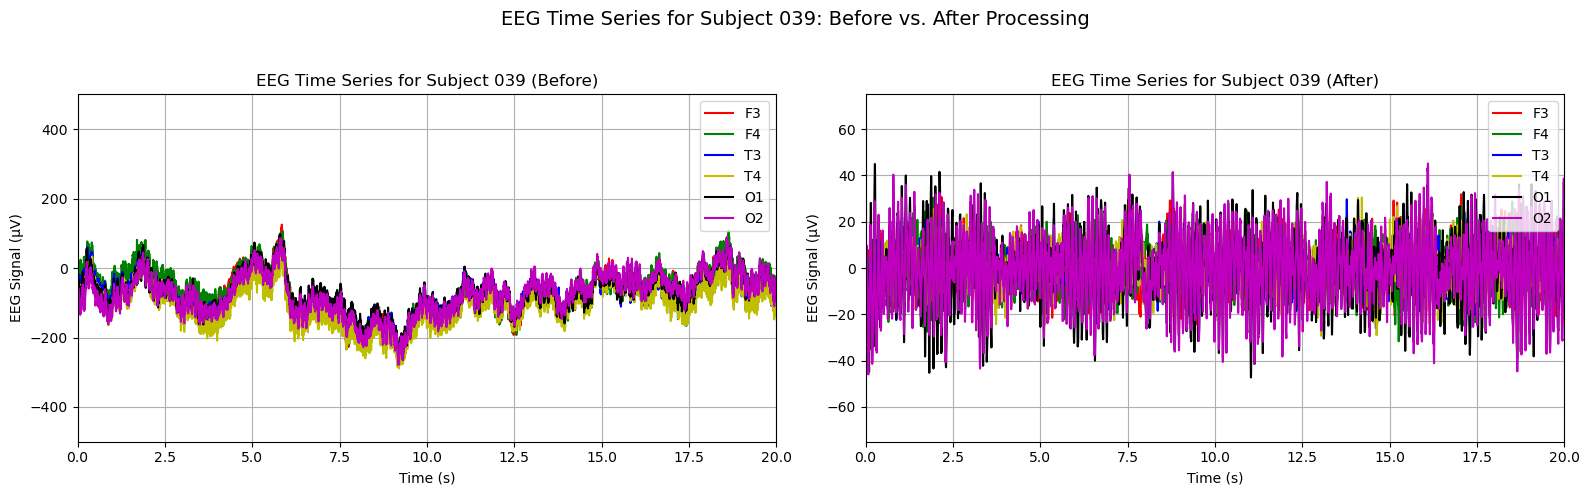

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


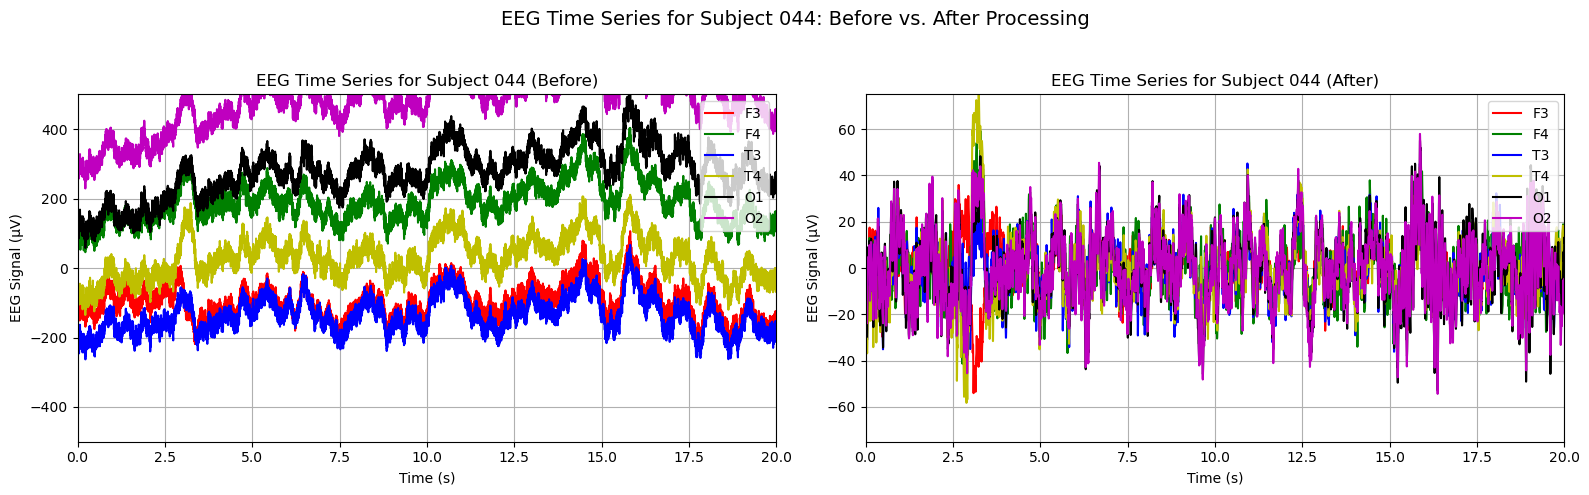

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


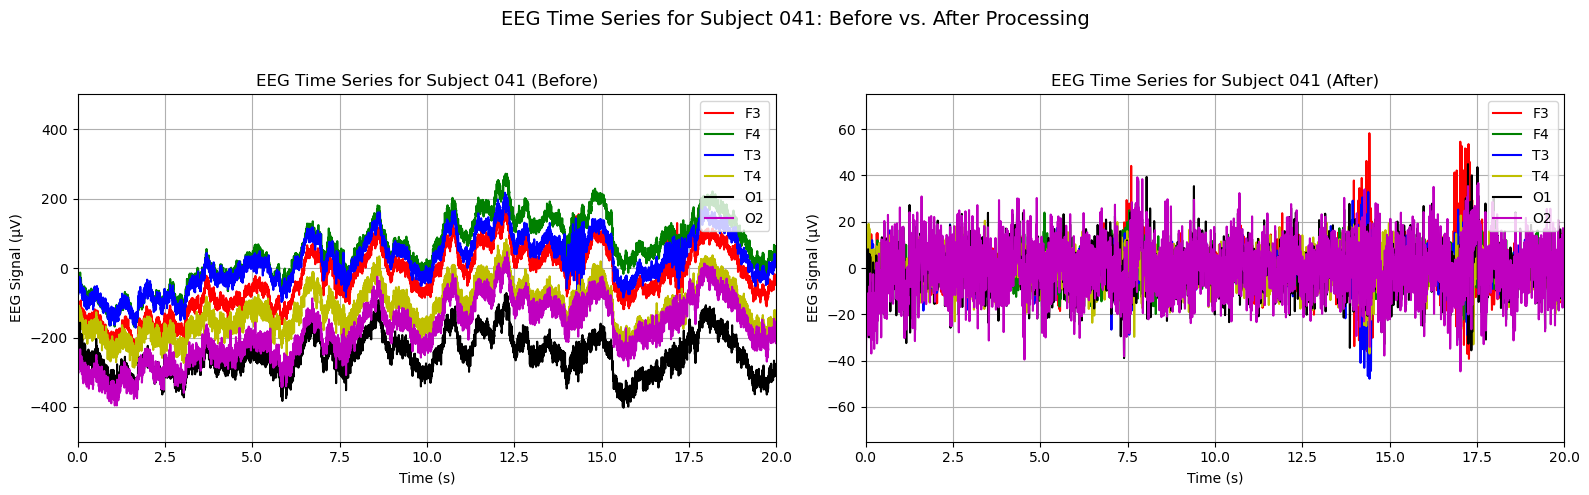

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


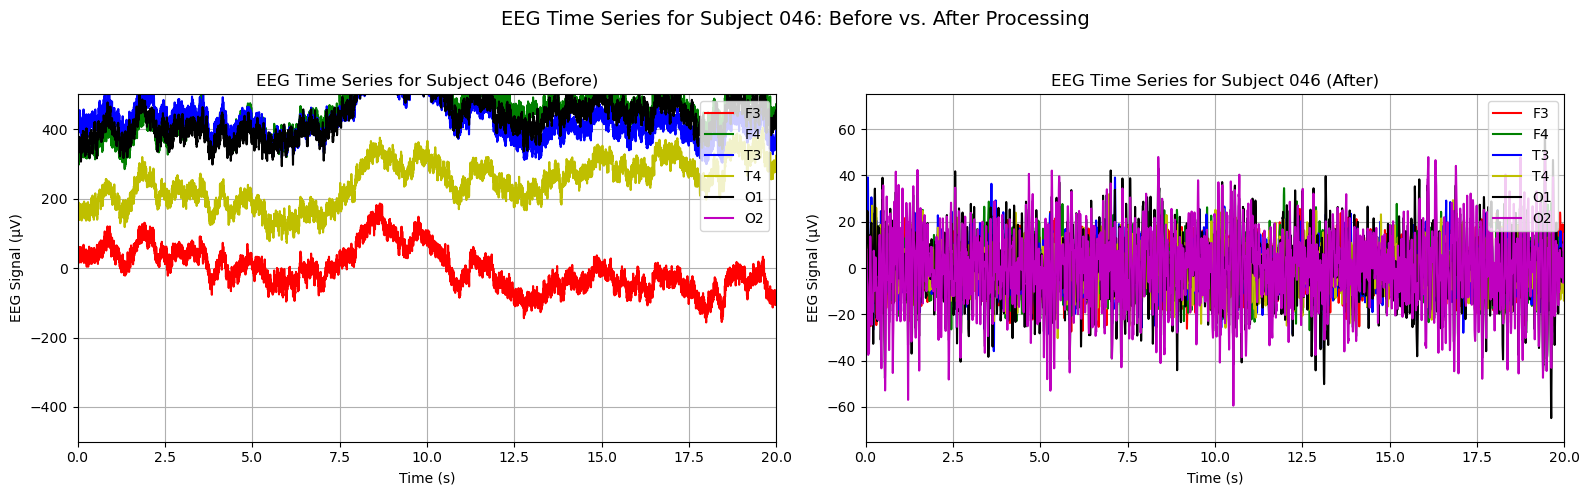

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [1, 4]
Number of eye artifact components removed: 2


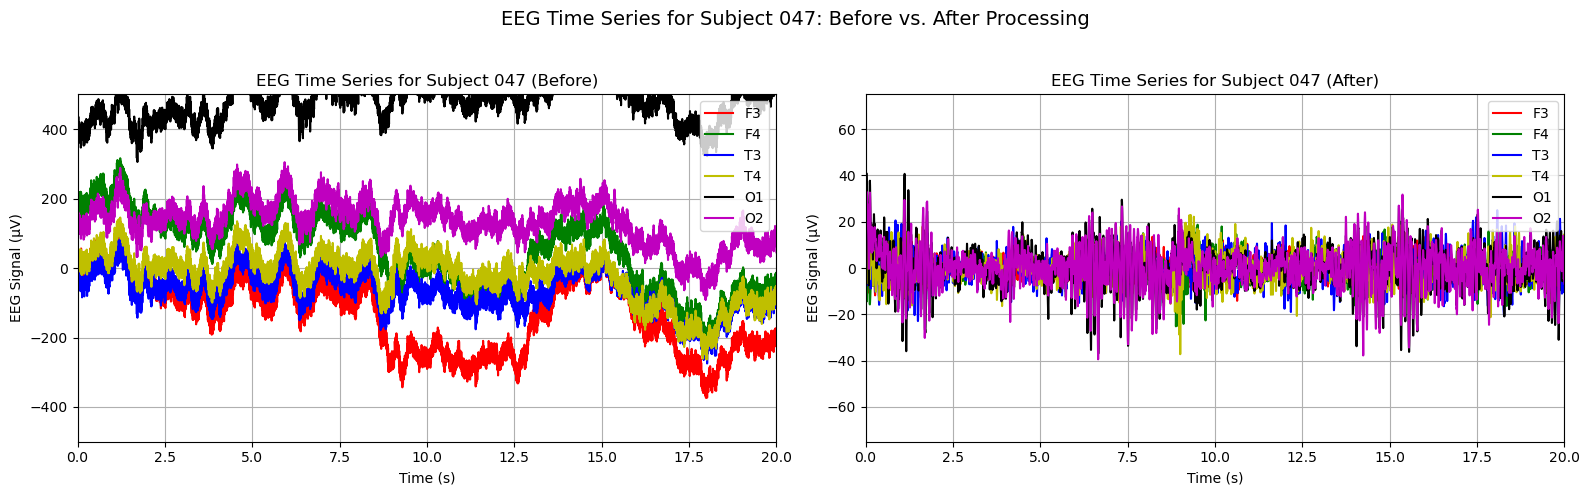

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [1, 4]
Number of eye artifact components removed: 2


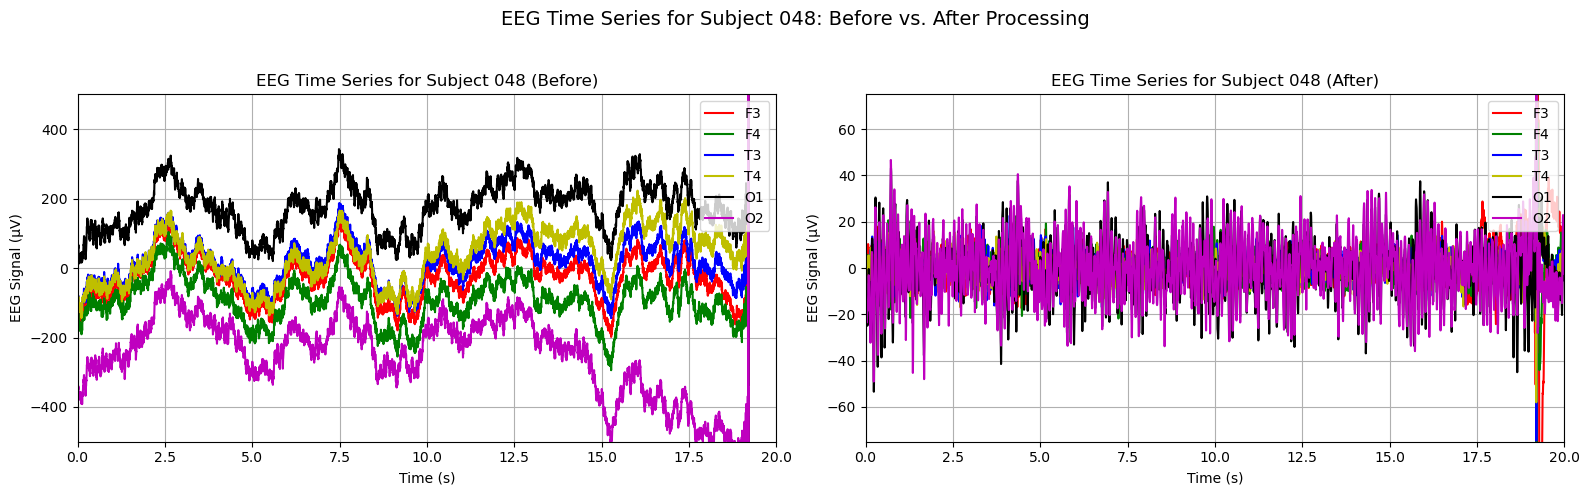

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0]
Number of eye artifact components removed: 1


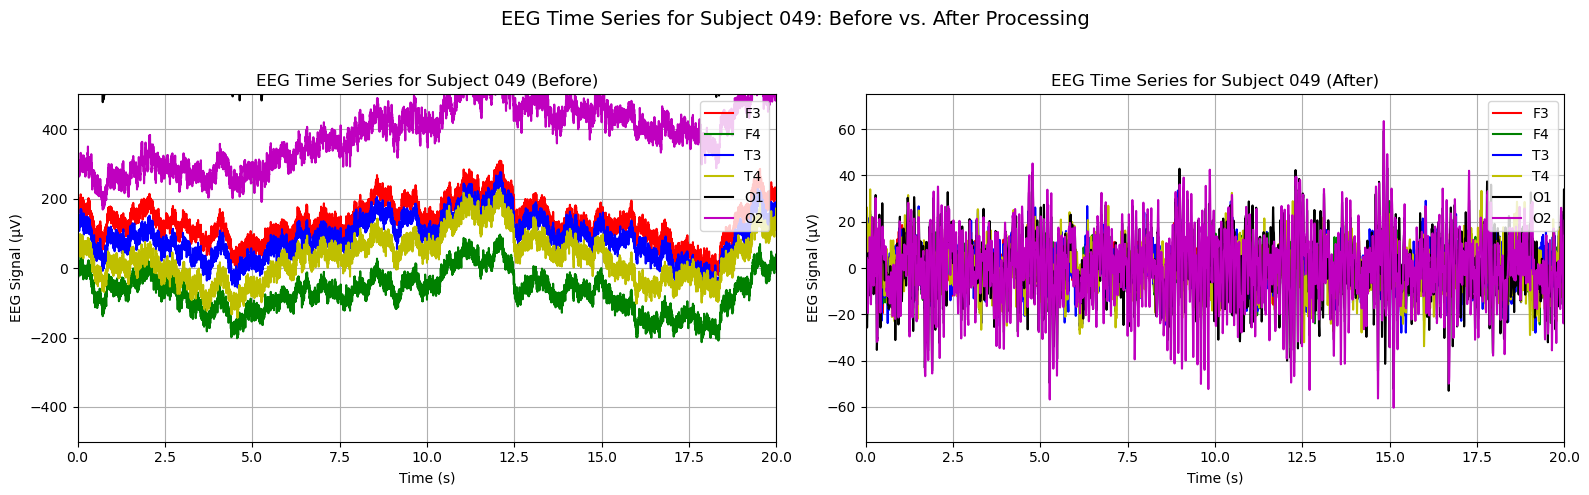

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 1]
Number of eye artifact components removed: 2


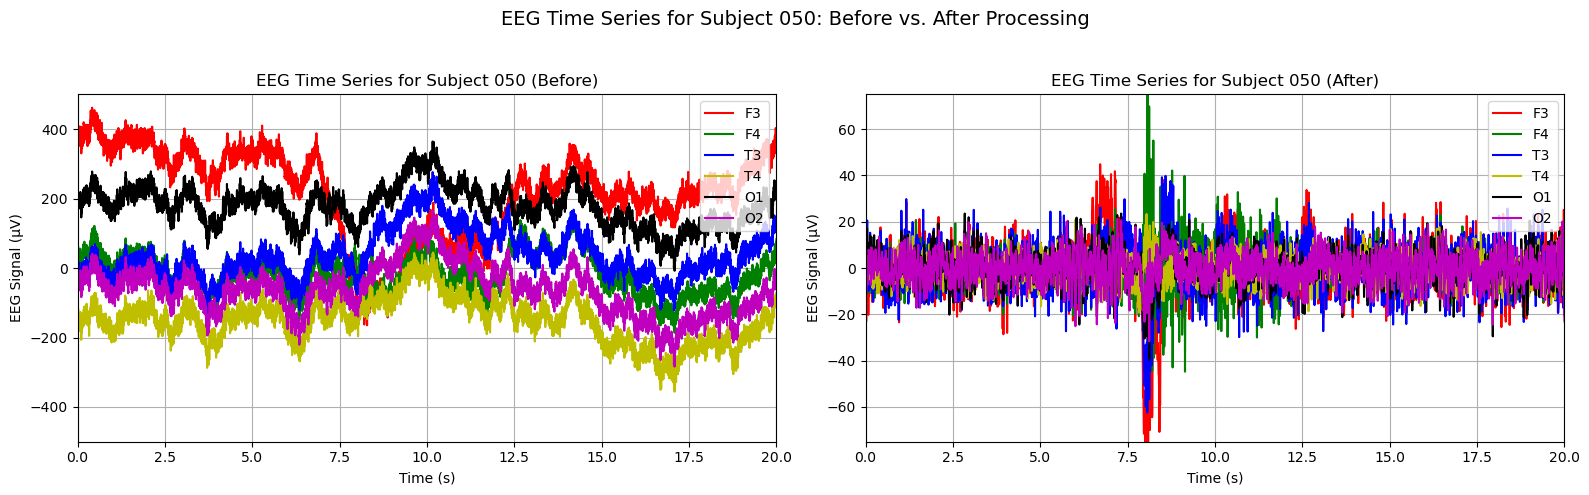

Synthetic EOG channel created from Fp1 and Fp2.
Band-pass filter applied: 1–45.0 Hz.
Total number of ICA components: 19
Identified EOG-related ICA components: [0, 4]
Number of eye artifact components removed: 2


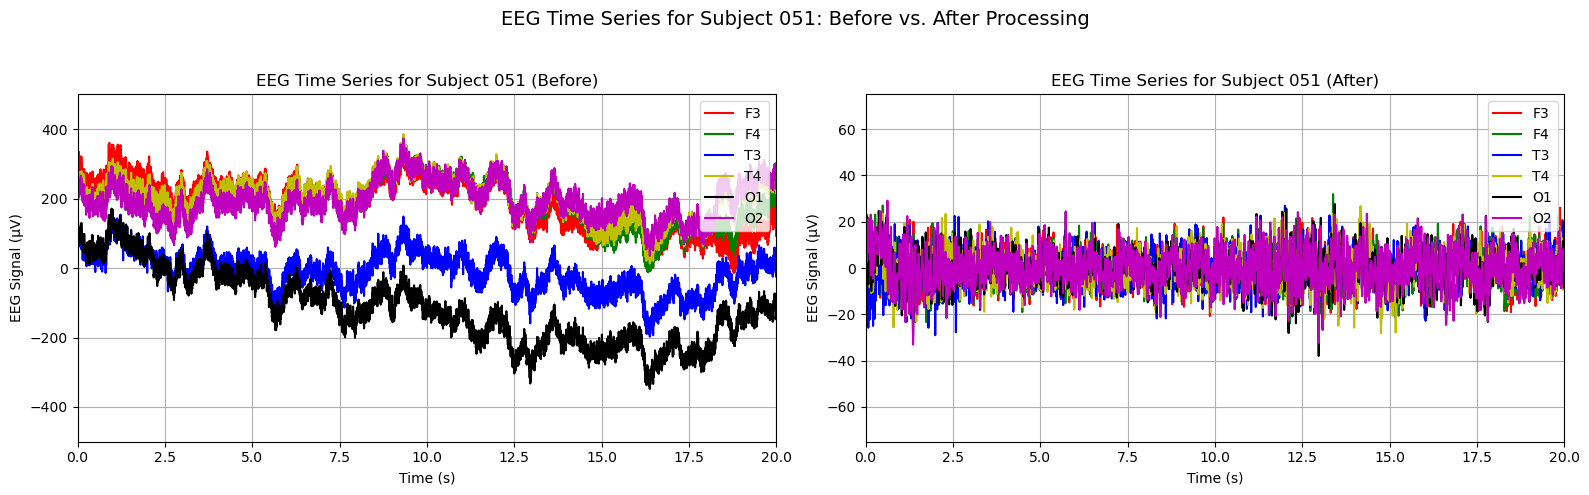

PSD computed for all subjects.
Frequency bins shape: (513,)


In [4]:
# Preprocess, Plot, Compute PSD, Relative Power, Stats
fs = 500  # Sampling frequency

# Containers for processed data
ad_processed_data = []
control_processed_data = []

# Process AD subjects
for fp, sid in zip(ad_files, ad_subject_ids):
    # Load unprocessed data and restrict to channels of interest
    raw_unproc = mne.io.read_raw_eeglab(fp, preload=True)
    raw_unproc.pick(channels_of_interest)
    data_unproc = raw_unproc.get_data()
    
    raw_clean_obj, num_removed = preprocess_eeg(fp, l_freq=1, h_freq=45.0)
    raw_clean_obj.pick(channels_of_interest)
    data_proc = raw_clean_obj.get_data()
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    plot_eeg_time_series(data_unproc, subject_id=sid + " (Before)", 
                           selected_channels=list(range(len(channels_of_interest))),
                           channel_names=channels_of_interest,
                           colors=["r", "g", "b", "y", "k", "m"], ax=axs[0])
    axs[0].set_ylim(-500, 500)
    plot_eeg_time_series(data_proc, subject_id=sid + " (After)", 
                           selected_channels=list(range(len(channels_of_interest))),
                           channel_names=channels_of_interest,
                           colors=["r", "g", "b", "y", "k", "m"], ax=axs[1])
    axs[1].set_ylim(-75, 75)
    plt.suptitle(f"EEG Time Series for {sid}: Before vs. After Processing", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    print(f"{sid}: {num_removed} eye artifact components were removed.")
    ad_processed_data.append(data_proc)

# Process Control subjects
for fp, sid in zip(control_files, control_subject_ids):
    raw_unproc = mne.io.read_raw_eeglab(fp, preload=True)
    raw_unproc.pick(channels_of_interest)
    data_unproc = raw_unproc.get_data()
    
    raw_clean_obj, num_removed = preprocess_eeg(fp, l_freq=1, h_freq=45.0)
    raw_clean_obj.pick(channels_of_interest)
    data_proc = raw_clean_obj.get_data()
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    plot_eeg_time_series(data_unproc, subject_id=sid + " (Before)", 
                           selected_channels=list(range(len(channels_of_interest))),
                           channel_names=channels_of_interest,
                           colors=["r", "g", "b", "y", "k", "m"], ax=axs[0])
    axs[0].set_ylim(-500, 500)
    plot_eeg_time_series(data_proc, subject_id=sid + " (After)", 
                           selected_channels=list(range(len(channels_of_interest))),
                           channel_names=channels_of_interest,
                           colors=["r", "g", "b", "y", "k", "m"], ax=axs[1])
    axs[1].set_ylim(-75, 75)
    plt.suptitle(f"EEG Time Series for {sid}: Before vs. After Processing", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    control_processed_data.append(data_proc)

# Compute PSD for Each Subject 
ad_psd_list = []
control_psd_list = []
frequencies = None

for data in ad_processed_data:
    f, psd = compute_psd_welch(data, fs=fs)
    if frequencies is None:
        frequencies = f
    ad_psd_list.append(psd)

for data in control_processed_data:
    f, psd = compute_psd_welch(data, fs=fs)
    control_psd_list.append(psd)

print("PSD computed for all subjects.")
print("Frequency bins shape:", frequencies.shape)

# Define Frequency Masks for each band
theta_mask = (frequencies >= 4) & (frequencies <= 7)
alpha_mask = (frequencies >= 8) & (frequencies <= 12)
gamma_mask = (frequencies >= 30) & (frequencies <= 45)
broad_mask = (frequencies >= 1) & (frequencies <= 45)

# Compute channel-wise relative power for each subject for each band
ad_theta_rel_channels = [compute_channel_relative_power(psd, theta_mask, broad_mask) for psd in ad_psd_list]
ad_alpha_rel_channels = [compute_channel_relative_power(psd, alpha_mask, broad_mask) for psd in ad_psd_list]
ad_gamma_rel_channels = [compute_channel_relative_power(psd, gamma_mask, broad_mask) for psd in ad_psd_list]

control_theta_rel_channels = [compute_channel_relative_power(psd, theta_mask, broad_mask) for psd in control_psd_list]
control_alpha_rel_channels = [compute_channel_relative_power(psd, alpha_mask, broad_mask) for psd in control_psd_list]
control_gamma_rel_channels = [compute_channel_relative_power(psd, gamma_mask, broad_mask) for psd in control_psd_list]

# Convert lists to arrays (shape: n_subjects x n_channels)
ad_theta_rel_channels = np.array(ad_theta_rel_channels)
ad_alpha_rel_channels = np.array(ad_alpha_rel_channels)
ad_gamma_rel_channels = np.array(ad_gamma_rel_channels)
control_theta_rel_channels = np.array(control_theta_rel_channels)
control_alpha_rel_channels = np.array(control_alpha_rel_channels)
control_gamma_rel_channels = np.array(control_gamma_rel_channels)

## Power Spectral Density Plots

In [ ]:
# Generate average PSD plots for each channel
import matplotlib.pyplot as plt
import numpy as np

# Convert PSD lists to numpy arrays for easier manipulation
ad_psd_array = np.array(ad_psd_list)    # Shape: (n_subjects, n_channels, n_freqs)
control_psd_array = np.array(control_psd_list)  # Shape: (n_subjects, n_channels, n_freqs)

# Average across subjects for each group
ad_psd_mean = np.mean(ad_psd_array, axis=0)    # Shape: (n_channels, n_freqs)
ad_psd_std = np.std(ad_psd_array, axis=0)
control_psd_mean = np.mean(control_psd_array, axis=0)
control_psd_std = np.std(control_psd_array, axis=0)

# Set up frequency band shading
theta_mask = (frequencies >= 4) & (frequencies <= 7)
alpha_mask = (frequencies >= 8) & (frequencies <= 12)
gamma_mask = (frequencies >= 30) & (frequencies <= 45)

# Plotting function with frequency band highlighting
def plot_psd_comparison(freq, ad_mean, ad_std, control_mean, control_std, channel_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot mean PSD with shaded error bands
    ax.semilogy(freq, ad_mean, 'r-', linewidth=2, label='AD')
    ax.fill_between(freq, ad_mean - ad_std, ad_mean + ad_std, color='r', alpha=0.2)
    
    ax.semilogy(freq, control_mean, 'b-', linewidth=2, label='Control')
    ax.fill_between(freq, control_mean - control_std, control_mean + control_std, color='b', alpha=0.2)
    
    # Highlight frequency bands
    # Theta (4-7 Hz)
    ax.axvspan(4, 7, alpha=0.2, color='green', label='Theta (4-7 Hz)')
    
    # Alpha (8-12 Hz)
    ax.axvspan(8, 12, alpha=0.2, color='purple', label='Alpha (8-12 Hz)')
    
    # Gamma (30-45 Hz)
    ax.axvspan(30, 45, alpha=0.2, color='orange', label='Gamma (30-45 Hz)')
    
    # Set axis limits and labels
    ax.set_xlim(1, 45)  # Limit to frequency range of interest
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=12)
    ax.set_title(f'Average PSD: {channel_name} Channel', fontsize=14)
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)
    
    # Add grid for readability
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    return fig

# Create plots for each channel
for i, channel in enumerate(channels_of_interest):
    fig = plot_psd_comparison(
        frequencies, 
        ad_psd_mean[i], 
        ad_psd_std[i], 
        control_psd_mean[i], 
        control_psd_std[i], 
        channel
    )
    
    # Optionally save the figure
    plt.savefig(f'psd_comparison_{channel}.png', dpi=300)
    plt.show()

# Create a combined figure with all channels in subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, channel in enumerate(channels_of_interest):
    ax = axes[i]
    
    # Plot on log scale
    ax.semilogy(frequencies, ad_psd_mean[i], 'r-', linewidth=2, label='AD')
    ax.fill_between(frequencies, ad_psd_mean[i] - ad_psd_std[i], 
                   ad_psd_mean[i] + ad_psd_std[i], color='r', alpha=0.2)
    
    ax.semilogy(frequencies, control_psd_mean[i], 'b-', linewidth=2, label='Control')
    ax.fill_between(frequencies, control_psd_mean[i] - control_psd_std[i], 
                   control_psd_mean[i] + control_psd_std[i], color='b', alpha=0.2)
    
    # Highlight frequency bands
    ax.axvspan(4, 7, alpha=0.2, color='green')
    ax.axvspan(8, 12, alpha=0.2, color='purple')
    ax.axvspan(30, 45, alpha=0.2, color='orange')
    
    # Set title and limits
    ax.set_title(f'{channel}', fontsize=12)
    ax.set_xlim(1, 45)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Only add labels to bottom row
    if i >= 3:
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
    
    # Only add y-label to left column
    if i % 3 == 0:
        ax.set_ylabel('PSD (µV²/Hz)', fontsize=10)
    
    # Only add legend to the first subplot
    if i == 0:
        ax.legend(loc='upper right', fontsize=10)

# Add a title for the entire figure
fig.suptitle('Power Spectral Density Comparison: AD vs Control', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the title

# Add legend for the colored bands
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color='green', alpha=0.2, label='Theta (4-7 Hz)'),
    plt.Rectangle((0,0), 1, 1, color='purple', alpha=0.2, label='Alpha (8-12 Hz)'),
    plt.Rectangle((0,0), 1, 1, color='orange', alpha=0.2, label='Gamma (30-45 Hz)'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 0))

plt.savefig('psd_comparison_all_channels.png', dpi=300)
plt.show()

Our Power Spectral Density plots reveal distinct spectral signatures between Alzheimer's disease patients and healthy controls across multiple brain regions. AD patients exhibit noticeably higher power in the theta band (4-7 Hz), particularly pronounced in temporal (T4) and occipital (O2) regions, visible as elevated spectral peaks in this frequency range. Conversely, control subjects demonstrate stronger alpha oscillations (8-12 Hz), especially in frontal, temporal, and occipital channels (F4, T3, O1), appearing as more prominent spectral peaks in the 8-12 Hz region. Both groups show similar spectral profiles in the gamma range (30-45 Hz) with minimal power differences. The log-scale visualization highlights these differences across the broad frequency spectrum while maintaining visibility of higher-frequency components. These spectral patterns align with previously documented EEG slowing in Alzheimer's disease, characterized by increased low-frequency activity and reduced alpha oscillations.

## Statistical Analysis

### Shapiro-Wilk Test

First, we use a Shapiro-Wilk test across each band and channel for our statistical analysis. This is to determine whether the data is normally distributed or not. A p-value less than 0.05 indicates that the data is *not* normally distributed, which was the case for most of our data.


Shapiro-Wilk Test for Theta Relative Power:
AD F3: stat = 0.843, p = 0.048
AD F4: stat = 0.891, p = 0.176
AD T3: stat = 0.977, p = 0.945
AD T4: stat = 0.956, p = 0.743
AD O1: stat = 0.877, p = 0.122
AD O2: stat = 0.930, p = 0.450
Control F3: stat = 0.979, p = 0.958
Control F4: stat = 0.970, p = 0.894
Control T3: stat = 0.894, p = 0.186
Control T4: stat = 0.952, p = 0.694
Control O1: stat = 0.834, p = 0.038
Control O2: stat = 0.930, p = 0.450

Shapiro-Wilk Test for Alpha Relative Power:
AD F3: stat = 0.863, p = 0.084
AD F4: stat = 0.802, p = 0.015
AD T3: stat = 0.838, p = 0.042
AD T4: stat = 0.893, p = 0.183
AD O1: stat = 0.859, p = 0.074
AD O2: stat = 0.847, p = 0.054
Control F3: stat = 0.910, p = 0.280
Control F4: stat = 0.930, p = 0.448
Control T3: stat = 0.927, p = 0.420
Control T4: stat = 0.910, p = 0.283
Control O1: stat = 0.964, p = 0.835
Control O2: stat = 0.944, p = 0.603

Shapiro-Wilk Test for Gamma Relative Power:
AD F3: stat = 0.879, p = 0.127
AD F4: stat = 0.932, p = 0.472

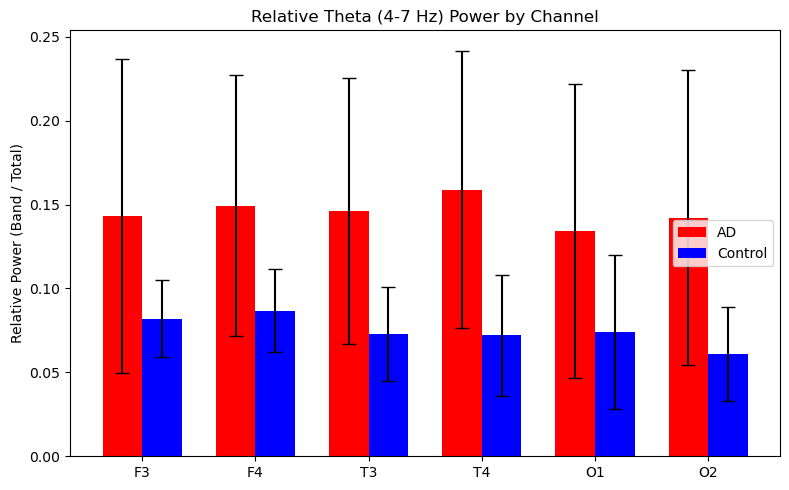

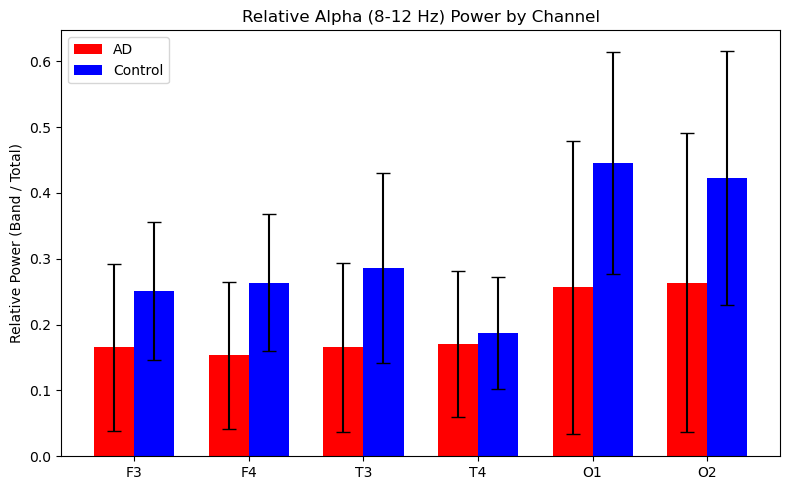

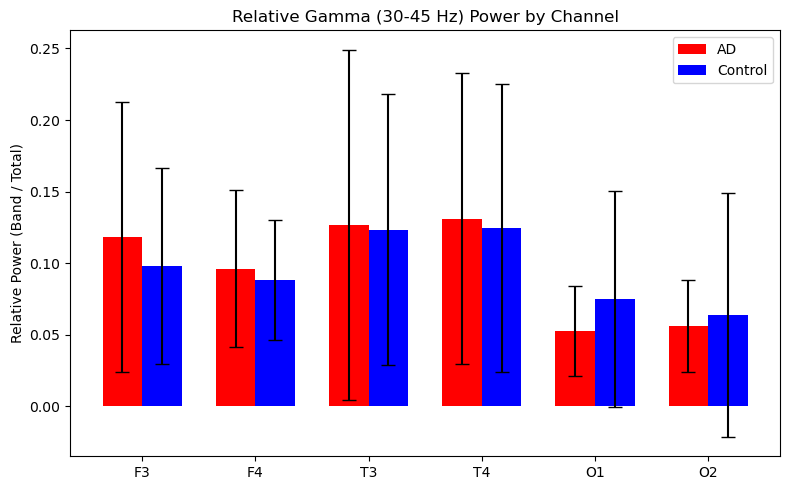

In [ ]:
# Channel-wise Shapiro-Wilk Test for Normality (Channel-wise for each band)
print("\nShapiro-Wilk Test for Theta Relative Power:")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(ad_theta_rel_channels[:, i])
    print(f"AD {ch}: stat = {stat:.3f}, p = {p_val:.3f}")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(control_theta_rel_channels[:, i])
    print(f"Control {ch}: stat = {stat:.3f}, p = {p_val:.3f}")

print("\nShapiro-Wilk Test for Alpha Relative Power:")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(ad_alpha_rel_channels[:, i])
    print(f"AD {ch}: stat = {stat:.3f}, p = {p_val:.3f}")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(control_alpha_rel_channels[:, i])
    print(f"Control {ch}: stat = {stat:.3f}, p = {p_val:.3f}")

print("\nShapiro-Wilk Test for Gamma Relative Power:")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(ad_gamma_rel_channels[:, i])
    print(f"AD {ch}: stat = {stat:.3f}, p = {p_val:.3f}")
for i, ch in enumerate(channels_of_interest):
    stat, p_val = shapiro(control_gamma_rel_channels[:, i])
    print(f"Control {ch}: stat = {stat:.3f}, p = {p_val:.3f}")

# Channel-wise bar plots for each band
def plot_channel_bar(ad_data, ctrl_data, channels, band_name):
    """
    ad_data, ctrl_data: arrays of shape (n_subjects, n_channels)
    channels: list of channel names
    band_name: string to label the plot
    """
    means_ad = np.mean(ad_data, axis=0)  # shape: (n_channels,)
    stds_ad = np.std(ad_data, axis=0)
    means_ctrl = np.mean(ctrl_data, axis=0)
    stds_ctrl = np.std(ctrl_data, axis=0)
    
    x = np.arange(len(channels))
    width = 0.35
    
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, means_ad, width, yerr=stds_ad, capsize=5, label="AD", color='red')
    plt.bar(x + width/2, means_ctrl, width, yerr=stds_ctrl, capsize=5, label="Control", color='blue')
    plt.xticks(x, channels)
    plt.ylabel("Relative Power (Band / Total)")
    plt.title(f"Relative {band_name} Power by Channel")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Bar plots for Theta, Alpha, Gamma
plot_channel_bar(ad_theta_rel_channels, control_theta_rel_channels, channels_of_interest, "Theta (4-7 Hz)")
plot_channel_bar(ad_alpha_rel_channels, control_alpha_rel_channels, channels_of_interest, "Alpha (8-12 Hz)")
plot_channel_bar(ad_gamma_rel_channels, control_gamma_rel_channels, channels_of_interest, "Gamma (30-45 Hz)")

### Mann-Whitney U Test

Since most of our data was not normally distributed, we will use a Mann-Whitney U test. This test observes whether there is any statistically significant difference between two groups with non-parametric distributions, unlike a t-test which uses data with normal distributions.

In [6]:
print("\nTheta Band Channel-wise Mann-Whitney U Tests:")
for i, ch in enumerate(channels_of_interest):
    u_stat, p_val = mannwhitneyu(ad_theta_rel_channels[:, i], control_theta_rel_channels[:, i], alternative='two-sided')
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.3f}")

print("\nAlpha Band Channel-wise Mann-Whitney U Tests:")
for i, ch in enumerate(channels_of_interest):
    u_stat, p_val = mannwhitneyu(ad_alpha_rel_channels[:, i], control_alpha_rel_channels[:, i], alternative='two-sided')
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.3f}")

print("\nGamma Band Channel-wise Mann-Whitney U Tests:")
for i, ch in enumerate(channels_of_interest):
    u_stat, p_val = mannwhitneyu(ad_gamma_rel_channels[:, i], control_gamma_rel_channels[:, i], alternative='two-sided')
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.3f}")


Theta Band Channel-wise Mann-Whitney U Tests:
F3: U = 71.000, p = 0.121
F4: U = 68.000, p = 0.186
T3: U = 76.000, p = 0.054
T4: U = 77.000, p = 0.045
O1: U = 75.000, p = 0.064
O2: U = 79.000, p = 0.031

Alpha Band Channel-wise Mann-Whitney U Tests:
F3: U = 25.000, p = 0.064
F4: U = 23.000, p = 0.045
T3: U = 23.000, p = 0.045
T4: U = 41.000, p = 0.521
O1: U = 23.000, p = 0.045
O2: U = 30.000, p = 0.140

Gamma Band Channel-wise Mann-Whitney U Tests:
F3: U = 54.000, p = 0.791
F4: U = 52.000, p = 0.910
T3: U = 51.000, p = 0.970
T4: U = 50.000, p = 1.000
O1: U = 45.000, p = 0.734
O2: U = 66.000, p = 0.241


## Corrections

### Bonferroni Correction
#### Code Explanation

- mannwhitneyu(x, y, alternative='two-sided'): Non-parametric test that compares distributions without assuming normality; ideal for EEG data that violates normality assumptions


- Bonferroni correction: Adjusts significance threshold by dividing alpha (0.05) by the number of tests (18) to control for multiple comparisons; resulting threshold: p < 0.00278


- cohens_d(x, y): Calculates standardized effect size as the difference between group means divided by pooled standard deviation; values above 0.8 indicate large effects


- Significance marking: Results flagged with '*' (p < 0.05) for uncorrected significance and '**' (p < 0.00278) for Bonferroni-corrected significance


- Combined results dataframe: Stores all statistics in one structure, enabling easy filtering of significant findings and export to CSV for further analysis

In [ ]:
# Define Bonferroni correction parameters
n_tests = 18  # 3 bands × 6 channels
alpha = 0.05
bonferroni_alpha = alpha / n_tests
print(f"\nBonferroni-corrected significance threshold: p < {bonferroni_alpha:.5f}")

# Function to calculate Cohen's d effect size
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.var(x, ddof=1) + 
                                               (ny-1)*np.var(y, ddof=1)) / dof)

# Mann-Whitney U tests with significance markers
print("\nTheta Band Channel-wise Mann-Whitney U Tests (with Bonferroni correction):")
theta_results = []
for i, ch in enumerate(channels_of_interest):
    ad_data = ad_theta_rel_channels[:, i]
    ctrl_data = control_theta_rel_channels[:, i]
    u_stat, p_val = mannwhitneyu(ad_data, ctrl_data, alternative='two-sided')
    sig = "**" if p_val < bonferroni_alpha else ("*" if p_val < 0.05 else "")
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.5f} {sig}")
    
    # Calculate effect size
    d = cohens_d(ad_data, ctrl_data)
    
    # Store results
    theta_results.append({
        'Band': 'Theta',
        'Channel': ch,
        'AD_Mean': np.mean(ad_data),
        'AD_SD': np.std(ad_data),
        'Control_Mean': np.mean(ctrl_data),
        'Control_SD': np.std(ctrl_data),
        'U_stat': u_stat,
        'P_value': p_val,
        'Significant': sig,
        'Cohens_d': d,
    })

print("\nAlpha Band Channel-wise Mann-Whitney U Tests (with Bonferroni correction):")
alpha_results = []
for i, ch in enumerate(channels_of_interest):
    ad_data = ad_alpha_rel_channels[:, i]
    ctrl_data = control_alpha_rel_channels[:, i]
    u_stat, p_val = mannwhitneyu(ad_data, ctrl_data, alternative='two-sided')
    sig = "**" if p_val < bonferroni_alpha else ("*" if p_val < 0.05 else "")
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.5f} {sig}")
    
    # Calculate effect size
    d = cohens_d(ad_data, ctrl_data)
    
    # Store results
    alpha_results.append({
        'Band': 'Alpha',
        'Channel': ch,
        'AD_Mean': np.mean(ad_data),
        'AD_SD': np.std(ad_data),
        'Control_Mean': np.mean(ctrl_data),
        'Control_SD': np.std(ctrl_data),
        'U_stat': u_stat,
        'P_value': p_val,
        'Significant': sig,
        'Cohens_d': d,
    })

print("\nGamma Band Channel-wise Mann-Whitney U Tests (with Bonferroni correction):")
gamma_results = []
for i, ch in enumerate(channels_of_interest):
    ad_data = ad_gamma_rel_channels[:, i]
    ctrl_data = control_gamma_rel_channels[:, i]
    u_stat, p_val = mannwhitneyu(ad_data, ctrl_data, alternative='two-sided')
    sig = "**" if p_val < bonferroni_alpha else ("*" if p_val < 0.05 else "")
    print(f"{ch}: U = {u_stat:.3f}, p = {p_val:.5f} {sig}")
    
    # Calculate effect size
    d = cohens_d(ad_data, ctrl_data)
    
    # Store results
    gamma_results.append({
        'Band': 'Gamma',
        'Channel': ch,
        'AD_Mean': np.mean(ad_data),
        'AD_SD': np.std(ad_data),
        'Control_Mean': np.mean(ctrl_data),
        'Control_SD': np.std(ctrl_data),
        'U_stat': u_stat,
        'P_value': p_val,
        'Significant': sig,
        'Cohens_d': d,
    })

# Combine all results
import pandas as pd
all_results = pd.DataFrame(theta_results + alpha_results + gamma_results)

# Save to CSV
all_results.to_csv("eeg_mann_whitney_results.csv", index=False)

# Print summary of significant findings
print("\n=== SUMMARY OF SIGNIFICANT FINDINGS ===")
sig_results = all_results[all_results['Significant'] != ""]
if len(sig_results) > 0:
    for _, row in sig_results.iterrows():
        band = row['Band']
        ch = row['Channel']
        ad_mean = row['AD_Mean']
        ctrl_mean = row['Control_Mean']
        effect = "higher" if ad_mean > ctrl_mean else "lower"
        
        print(f"\n{band} band, {ch} channel: AD shows {effect} power")
        print(f"  • AD: {ad_mean:.3f} ± {row['AD_SD']:.3f}")
        print(f"  • Control: {ctrl_mean:.3f} ± {row['Control_SD']:.3f}")
        print(f"  • Mann-Whitney: U = {row['U_stat']:.1f}, p = {row['P_value']:.5f} {row['Significant']}")
        
        # Interpret effect size
        d = row['Cohens_d']
        if abs(d) > 0.8:
            effect_size = "Large"
        elif abs(d) > 0.5:
            effect_size = "Medium"
        else:
            effect_size = "Small"
        
        print(f"  • Effect size: {effect_size} (d = {d:.2f})")
else:
    print("No significant findings after applying Bonferroni correction (p < 0.00278)")
    print("Consider reporting uncorrected p-values with appropriate caveats.")

While none of our findings survived the Bonferroni-corrected threshold (p < 0.00278), we observed consistent patterns across multiple brain regions with large effect sizes (Cohen's d ranging from 0.84 to 1.29). Notably, AD patients exhibited higher theta power in temporal (T4) and occipital (O2) regions, alongside lower alpha power in frontal (F4) and temporal-occipital (T3, O1) regions compared to controls. These substantial effect sizes, despite the relatively small sample size (n=10 per group), suggest meaningful neurophysiological differences between groups. The consistent spatial distribution of these effects aligns with previous literature on AD-related EEG changes, supporting their clinical relevance even though they didn't reach statistical significance after correction for multiple comparisons.

## Results & Conclusion

Our spectral analysis revealed consistent patterns distinguishing Alzheimer's disease patients from healthy controls. The power spectral density profiles demonstrated increased theta power (4-7 Hz) in AD patients, particularly pronounced in temporal (T4) and occipital (O2) regions, alongside reduced alpha power (8-12 Hz) in frontal, temporal, and occipital channels (F4, T3, O1). Mann-Whitney U tests confirmed these observations with uncorrected statistical significance (p < 0.05) across multiple channels. Although no comparisons survived the stringent Bonferroni correction (p < 0.00278), the large effect sizes (Cohen's d ranging from 0.84 to 1.29) suggest meaningful neurophysiological differences despite our limited sample size. The gamma band (30-45 Hz) showed no significant differences between groups.

Our findings align with the established studies on EEG slowing in Alzheimer's disease, characterized by shifts toward lower frequencies and reduced alpha activity. The spatial distribution of these differences - especially the prominent theta increases in temporal and occipital regions - may reflect underlying pathophysiological processes related to neurodegeneration. While our statistical power was limited by the small sample size and multiple comparison requirements, the consistency of patterns across channels and substantial effect sizes support the potential use of resting-state EEG as a biomarker for AD. Future work should expand this analysis to larger populations, explore correlations with cognitive measures, and investigate machine learning approaches to improve classification accuracy.